In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from imutils import build_montages
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sn
import pandas as pd

# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cpu"):
  print('Set the runtime to GPU!')
else:
  print(f"Device: {device}")

Device: cuda


In [2]:
# Add label to save files
save_lab = '-net3'

##### change path to x-ray files location !!!!! ######
path = "/pine/scr/k/a/kathlyne/comp562/final_project/" 
######################################################

# Select epoch based on training results
sel_epoch = 12

**Load dataset**

In [3]:
cols = ["Filename","BrixiaScoreGlobal","ConsensusTestset"]
cutoff = 8 # optimal cutoff based on literature (add citation)

# Get list of file paths to images
metadata = pd.read_csv(os.path.join(path,"metadata.csv"),sep=";",usecols=cols)
file_list = metadata.Filename.copy()

for i in range(len(file_list)):
    tmp = str(os.path.splitext(file_list[i])[0])
    file_list[i] = os.path.join(path,"segmented_png",(tmp+".png"))

# Define image labels based on cutoff value
labels = (metadata.BrixiaScoreGlobal >= cutoff)
  # 0 = low Brixia score (< 8)
  # 1 = high Brixia score (>= 8)

# Split into training/val and test sets
trainval_files = file_list[(metadata.ConsensusTestset == 0)]
trainval_labels = labels[metadata.ConsensusTestset == 0]
test_files = file_list[metadata.ConsensusTestset == 1]
test_labels = labels[metadata.ConsensusTestset == 1]


In [4]:
### Data Pre-processing ###
transform = transforms.Compose(
    [transforms.ToTensor(), # convert to tensor
     transforms.Normalize((0.5,), (0.5,))]) # normalize

### Define custom dataset ###
class XRayDataset(Dataset):
    def __init__(self,image_paths,image_labels,transform=False):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        image_filepath = self.image_paths.iloc[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        label = (self.image_labels.iloc[idx]).astype(int)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

### Create datasets ###
trainval_set = XRayDataset(trainval_files,trainval_labels,transform)
test_set = XRayDataset(test_files,test_labels,transform)

In [5]:
batch_size = 32 # randomly-chosen - ideally, needs a hyperparameter search

# Load the datasets using Pytorch DataLoader
trainvalloader = torch.utils.data.DataLoader(trainval_set,batch_size=batch_size,shuffle=True,num_workers=0)
testloader = torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=True,num_workers=0)

image_size = 512 # pixel dimensions of image

**Creating the model**

In [6]:
## CNN architecture
class simple_cnn(torch.nn.Module):
  def __init__(self,input_channels,n_filters,filt_size,input_size,n_classes):
    super().__init__()

    # inputs
    self.input_channels = input_channels # number of channels in the input image
    self.n_filters = n_filters # list of number of filters in each layer
    self.filt_size = filt_size # list of filter sizes
    self.input_size = input_size  # size of the input image
    self.n_classes = n_classes;

    # avg pooling
    self.pool = torch.nn.AvgPool2d(2,2) 

    # conv layers
    self.conv0 = torch.nn.Conv2d(in_channels = input_channels, out_channels = n_filters[0], kernel_size = filt_size[0], padding = 0, stride = 2)
    self.conv1 = torch.nn.Conv2d(in_channels = n_filters[0], out_channels = n_filters[1], kernel_size = filt_size[1], padding = 0, stride = 2)
    self.conv2 = torch.nn.Conv2d(in_channels = n_filters[1],out_channels = n_filters[2], kernel_size = filt_size[2], padding = 0, stride = 2)
    
    # linear layer - applies a linear transformation
    self.fc0 = torch.nn.Linear(in_features = 288, out_features = 64)
    self.fc1 = torch.nn.Linear(in_features = 64, out_features = 2) 
    
    # batch normalization
    self.batchnorm1 = torch.nn.BatchNorm2d(n_filters[0])
    self.batchnorm2 = torch.nn.BatchNorm2d(n_filters[1])
    self.batchnorm3 = torch.nn.BatchNorm2d(n_filters[2])

    # dropout
    self.drop2d1 = torch.nn.Dropout2d(0.2)
    self.drop2d2 = torch.nn.Dropout2d(0.3)

  def forward(self,x):
    x = self.conv0(x)
    x = self.batchnorm1(x)
    x = self.drop2d1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv1(x)
    x = self.batchnorm2(x)
    x = self.drop2d2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.batchnorm3(x)
    x = self.drop2d2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc0(x)
    x = F.relu(x)
    x = self.fc1(x)
    return x

In [7]:
# Model
input_channels = 1 # grayscale image
n_filters = [8,16,32] 
filt_size = [16,16,16]
input_size = image_size
n_classes = 2
model = simple_cnn(input_channels,n_filters,filt_size,input_size,n_classes).to(device)

In [8]:
# # Load model at selected epoch defined above
model.load_state_dict(torch.load(path+'/covid_xray_classifier'+save_lab+'epoch'+str(sel_epoch)+'.pth'))

<All keys matched successfully>

**Train on combined test and validation set**

In [9]:
### Cost function ###
# Cross Entropy Loss
loss_fn = torch.nn.CrossEntropyLoss()

### Optimizer ###
# AdamW Optimizer (with L2 regularization)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for idx,data in enumerate(trainvalloader):
    ### Get data, send it to the GPU
    img,lab = data
    img = img.to(device)
    lab = lab.to(device)

    ### Model calculations
    # zero the gradients out
    optimizer.zero_grad()
    # get the predictions of the model and compute the loss
    out = model(img)
    # print(out.shape,lab.shape)
    loss = loss_fn(out,lab)
    # calculate the gradient and take a step with the model
    loss.backward()
    optimizer.step()

In [10]:
# # Save the final model
PATH = path+'/covid_xray_classifier'+save_lab+'-final.pth'
torch.save(model.state_dict(), PATH)

**Running the model on the test set**

In [11]:
correct = 0
total = 0

lab_pred = []
lab_true = []

with torch.no_grad():
    # iterate over test data
    for data in testloader:
        img, lab = data
        img = img.to(device)
        lab = lab.to(device)
        # calculate outputs by running images through the network
        out = model(img)
        # the class with the highest energy is what we choose as prediction
        pred = torch.argmax(out.data, 1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

        lab_pred.extend(pred.tolist()) # Save predictions
        lab_true.extend(lab.tolist()) # Save true labels

print(f'Accuracy of the network on the {total} test images: {100 * correct // total}%')

Accuracy of the network on the 150 test images: 76%


**Generate Confusion Matrix**

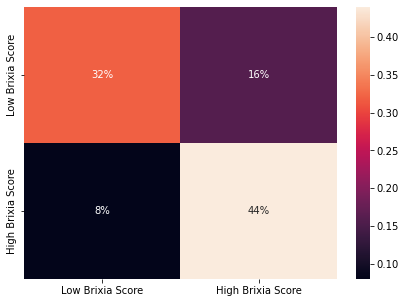

In [29]:
# Classes
classes = ('Low Brixia Score','High Brixia Score')

# Build confusion matrix
cf_matrix = confusion_matrix(lab_true, lab_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True,fmt='2.0%')
plt.savefig(path+'/confusion_matrix'+save_lab+'.png')